In [1]:
#this notebook ran on google.colab that's why you may see some specific code used only on colab platform
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import numpy as np
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
from sklearn.metrics import recall_score, precision_score, f1_score

from PIL import Image
import os, sys
from tqdm import tqdm

%matplotlib inline

In [3]:
channels = 3
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 64, 2, padding=1, stride=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.3),
                                        nn.Conv2d(64, 32, 2, padding=1, stride=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.3),)
        self.linear_layers = nn.Sequential(nn.Linear(2048, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256,2), nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [4]:
import tarfile
tar = tarfile.open('drive/My Drive/internship_data.tar.gz', 'r')
tar.extractall()

In [5]:
os.mkdir('new_images_wb/')
os.mkdir('new_images_wb/female/')
os.mkdir('new_images_wb/male/')

In [6]:
def resize(path, gender_file):
    dirs = os.listdir(path)
    for item in tqdm(dirs):
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            #im = bw_convert(im) #if you want to make pictures black-white
            imResize = im.resize((32,32), Image.ANTIALIAS)
            imResize.save('new_images_wb/'+gender_file+f.split('/')[-1] + '.jpg', 'JPEG', quality=90)

def bw_convert(img):
    arr = np.asarray(img, dtype='uint8')
    x, y, _ = arr.shape
 
    k = np.array([[[0.2989, 0.587, 0.114]]])
    arr2 = np.round(np.sum(arr * k, axis=2)).astype(np.uint8).reshape((x, y))
 
    img2 = Image.fromarray(arr2)
    return img2

In [7]:
#main problem of this dataset is that all pictures have different size, that's why we need to resize them
path = "internship_data/female/"
resize(path,'female/')
path = "internship_data/male/"
resize(path,'male/')

100%|██████████| 50002/50002 [01:28<00:00, 564.33it/s]


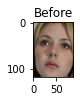

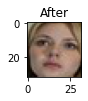

In [41]:
#example of image before and after resizing
dirs = os.listdir('internship_data/female')
image = plt.imread('internship_data/female/'+dirs[3])
image_resized = plt.imread('new_images_wb/female/'+dirs[3].split('/')[-1])
plt.figure(figsize=(1,1))
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.title('Before')
plt.figure(figsize=(1,1))
plt.imshow(image_resized, cmap=plt.cm.Greys_r)
plt.title('After')
print('')

In [8]:
dirs_f = ['new_images_wb/female/'+ i for i in os.listdir('new_images_wb/female')]
dirs_m = ['new_images_wb/male/'+ i for i in os.listdir('new_images_wb/male')]

In [9]:
#extracting images
X = []
y = []
for d in dirs_f:
    image = plt.imread(d)
    X.append(image.reshape((3,32,32)))
    y.append(1)
for d in dirs_m:
    image = plt.imread(d)
    X.append(image.reshape((3,32,32)))
    y.append(0)
X = np.array(X)
y = np.array(y)

In [10]:
#normalization
X = X.astype('float32')
X /= 255

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.astype('float32'), y, test_size=0.1, random_state=42)

In [12]:
X_test = torch.from_numpy(X_test).cuda()
X_train = torch.from_numpy(X_train).cuda()
y_test = torch.from_numpy(y_test).cuda()
y_train = torch.from_numpy(y_train).cuda()

In [13]:
dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

In [14]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [16]:
learning_rate=0.0001
epochs=200
network = ConvClassifier().cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

for epoch in range(epochs):
    losses_train = []
    accuracies_train = []
    for X, y in train_loader:
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y.squeeze())
        losses_train.append(loss_batch.item())
        loss_batch.backward()
        optimizer.step()
        accuracies_train.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
    losses_test = []
    accuracies_test = []
    for X, y in test_loader:
        prediction = network(X)
        loss_batch = loss(prediction, y.squeeze())
        losses_test.append(loss_batch.item())
        accuracies_test.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
    clear_output(True)
    print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(epoch, 
                                                                                               np.mean(losses_train), np.mean(losses_test),
                                                                                               np.mean(accuracies_train), np.mean(accuracies_test)))

Epoch 199... (Train/Test) NLL: 0.367/0.404	Accuracy: 0.945/0.906


In [26]:
prediction_test = network(X_test) 
y_predict = np.argmax(prediction_test.cpu().data.numpy(), axis=1)
print('f1 score: ', f1_score(y_test.cpu().data.numpy(), y_predict))

f1 score:  0.9057054664940755
